### GEDI vs FIA data

In [18]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from mgwr.gwr import GWR, MGWR, GWRResults
from mgwr.sel_bw import Sel_BW
from scipy import stats
from sklearn.preprocessing import StandardScaler
from geopandas import GeoDataFrame
from matplotlib_scalebar.scalebar import ScaleBar

import seaborn as sns
sns.set(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

scaler = StandardScaler()
%matplotlib inline


df = pd.read_csv('./data/gedi_fia_sorted.csv').sort_values(by='GEOID').reset_index(drop=True)

In [19]:
df.head()

,GEOID,NAMELSAD,v0_l4b_mean_mean,fia_mean_mean
0,1001,Autauga County,108.925303,74.568652
1,1003,Baldwin County,84.959613,52.835885
2,1005,Barbour County,113.760022,80.503963
3,1007,Bibb County,135.684162,95.942451
4,1009,Blount County,120.726929,67.317652


In [20]:
import geopandas as gpd
from geopandas import GeoDataFrame

counties = gpd.read_file('https://cdn.jsdelivr.net/npm/us-atlas@3/counties-10m.json')\
                                                                            .sort_values(by='id').reset_index(drop=True)

empty = counties['geometry'].is_empty
counties_non_empty = counties[~empty]

In [21]:
counties_non_empty['lon'] = counties_non_empty['geometry'].centroid.x
counties_non_empty['lat'] = counties_non_empty['geometry'].centroid.y
counties_non_empty['id'] = counties_non_empty['id'].astype('int')

In [22]:
counties_non_empty.head()

,id,name,geometry,lon,lat
0,1001,Autauga,"POLYGON ((-86.91684 32.66395, -86.71225 32.661...",-86.641721,32.535922
1,1003,Baldwin,"POLYGON ((-88.00799 30.68468, -88.02593 30.753...",-87.723428,30.727208
2,1005,Barbour,"POLYGON ((-85.65700 31.88049, -85.64982 31.911...",-85.392290,31.869504
3,1007,Bibb,"POLYGON ((-87.42293 33.00328, -87.31884 33.005...",-87.128405,32.997662
4,1009,Blount,"POLYGON ((-86.96350 33.85804, -86.92043 33.873...",-86.566051,33.981451


In [23]:
data = df.merge(counties_non_empty, left_on='GEOID', right_on='id', how='inner')

In [24]:
data.dropna(inplace=True)

In [25]:
data.head()

,GEOID,NAMELSAD,v0_l4b_mean_mean,fia_mean_mean,id,name,geometry,lon,lat
0,1001,Autauga County,108.925303,74.568652,1001,Autauga,"POLYGON ((-86.91684 32.66395, -86.71225 32.661...",-86.641721,32.535922
1,1003,Baldwin County,84.959613,52.835885,1003,Baldwin,"POLYGON ((-88.00799 30.68468, -88.02593 30.753...",-87.723428,30.727208
2,1005,Barbour County,113.760022,80.503963,1005,Barbour,"POLYGON ((-85.65700 31.88049, -85.64982 31.911...",-85.392290,31.869504
3,1007,Bibb County,135.684162,95.942451,1007,Bibb,"POLYGON ((-87.42293 33.00328, -87.31884 33.005...",-87.128405,32.997662
4,1009,Blount County,120.726929,67.317652,1009,Blount,"POLYGON ((-86.96350 33.85804, -86.92043 33.873...",-86.566051,33.981451


In [26]:
gdf = GeoDataFrame(data, crs="EPSG:4326")  # change the EPSG, see whether the result changes

<AxesSubplot:>

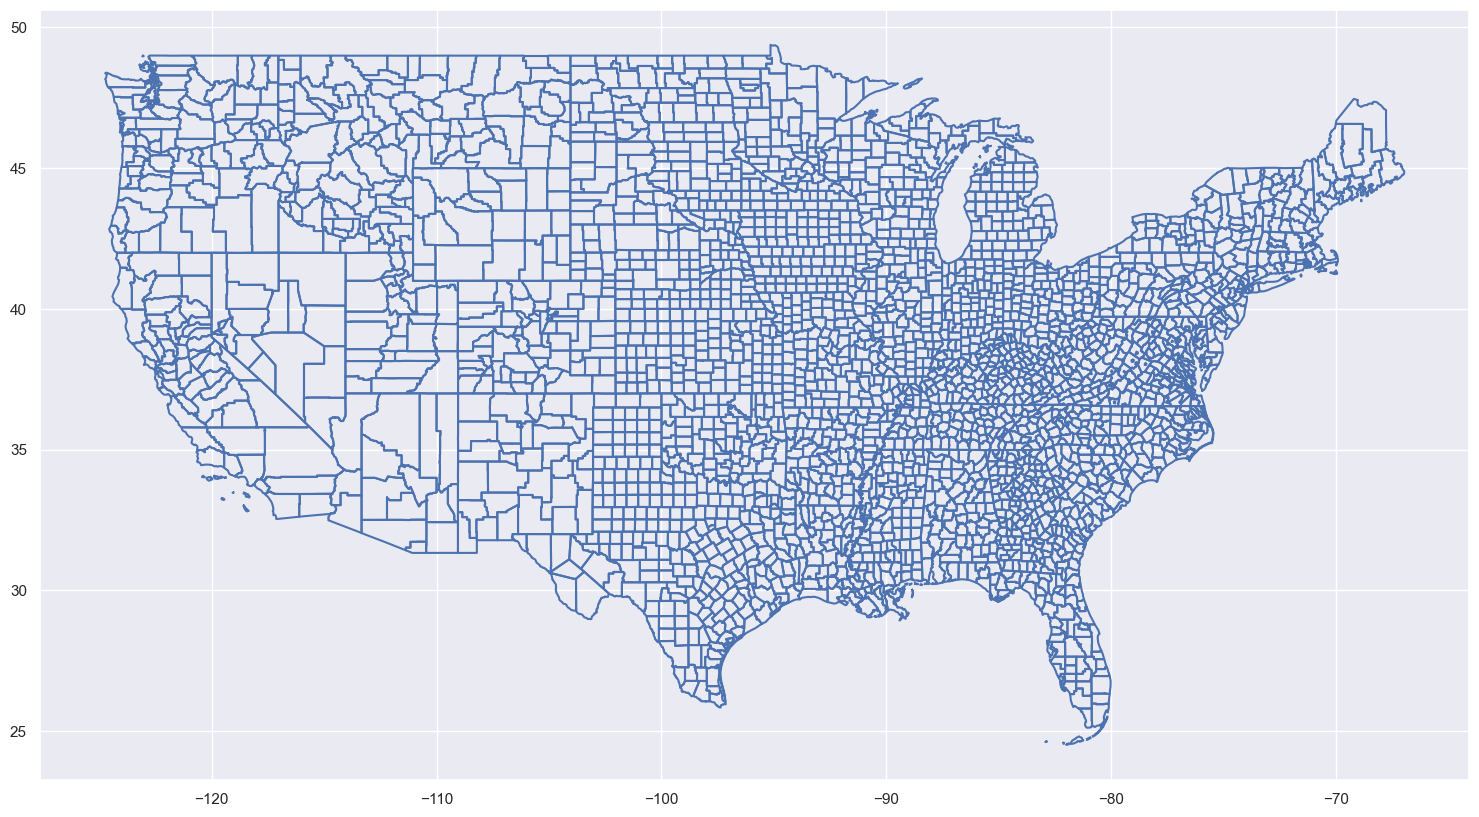

In [27]:
gdf.boundary.plot()

In [28]:
g_y = gdf['fia_mean_mean'].values.reshape((-1,1))
g_X = gdf[['v0_l4b_mean_mean']].values

u = gdf['lon']
v = gdf['lat']

g_coords = list(zip(u,v))

### Calculate LWCC using the Old Algo

In [29]:
gwr_selector_o = Sel_BW(g_coords, g_y, g_X)
gwr_bw_o = gwr_selector_o.search()
print(gwr_bw_o)
gwr_results_o = GWR(g_coords, g_y, g_X, gwr_bw_o, constant=True, lwcc=False).fit()
gwr_results_o.summary()

46.0
Model type                                                         Gaussian
Number of observations:                                                3107
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            363.464
Log-likelihood:                                                   -1075.246
AIC:                                                               2154.491
AICc:                                                              2156.499
BIC:                                                             -24605.123
R2:                                                                   0.883
Adj. R2:                                                              0.883

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- -

In [30]:
"""Local collinearity formula implementation. Extracted from MGWR codebase, line 1092, gwr.py, __author__ = Taylor Oshan"""

# x_scaled = scaler.fit_transform(x)
# y_scaled = scaler.fit_transform(y)


x_ = np.hstack((g_X, g_y))

def corr(cov):
    invsd = np.diag(1 / np.sqrt(np.diag(cov)))
    cors = np.dot(np.dot(invsd, cov), invsd)
    return cors

corr_mat = np.ndarray(shape=(len(x_), 1))


for i in range(len(x_)):
    wi_ = gwr_results_o.model._build_wi(i, gwr_bw_o)
    sw = np.sum(wi_)
    wi_ = wi_/sw
    corr_mat[i] = corr(np.cov(x_[:, 0], x_[:, 1], aweights=wi_))[0][1]
    
gdf['gwr_calc'] = corr_mat
corr_mat.mean()

0.8399729405980274

In [31]:
corr_mat.min()

-0.14113845657723456

In [32]:
gwr_selector_n = Sel_BW(g_coords, g_y, g_X)
gwr_bw_n = gwr_selector_n.search()
print(gwr_bw_n)
gwr_results_n = GWR(g_coords, g_y, g_X, gwr_bw_n, constant=False, lwcc=True).fit()
gwr_results_n.summary()

46.0
Model type                                                         Gaussian
Number of observations:                                                3107
Number of covariates:                                                     1

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         680687.223
Log-likelihood:                                                  -12781.145
AIC:                                                              25564.291
AICc:                                                             25566.294
BIC:                                                             655710.594
R2:                                                                   0.882
Adj. R2:                                                              0.882

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- -

In [33]:
gdf['new_algo_params'] = gwr_results_n.params

In [34]:
from utils import compare_surfaces

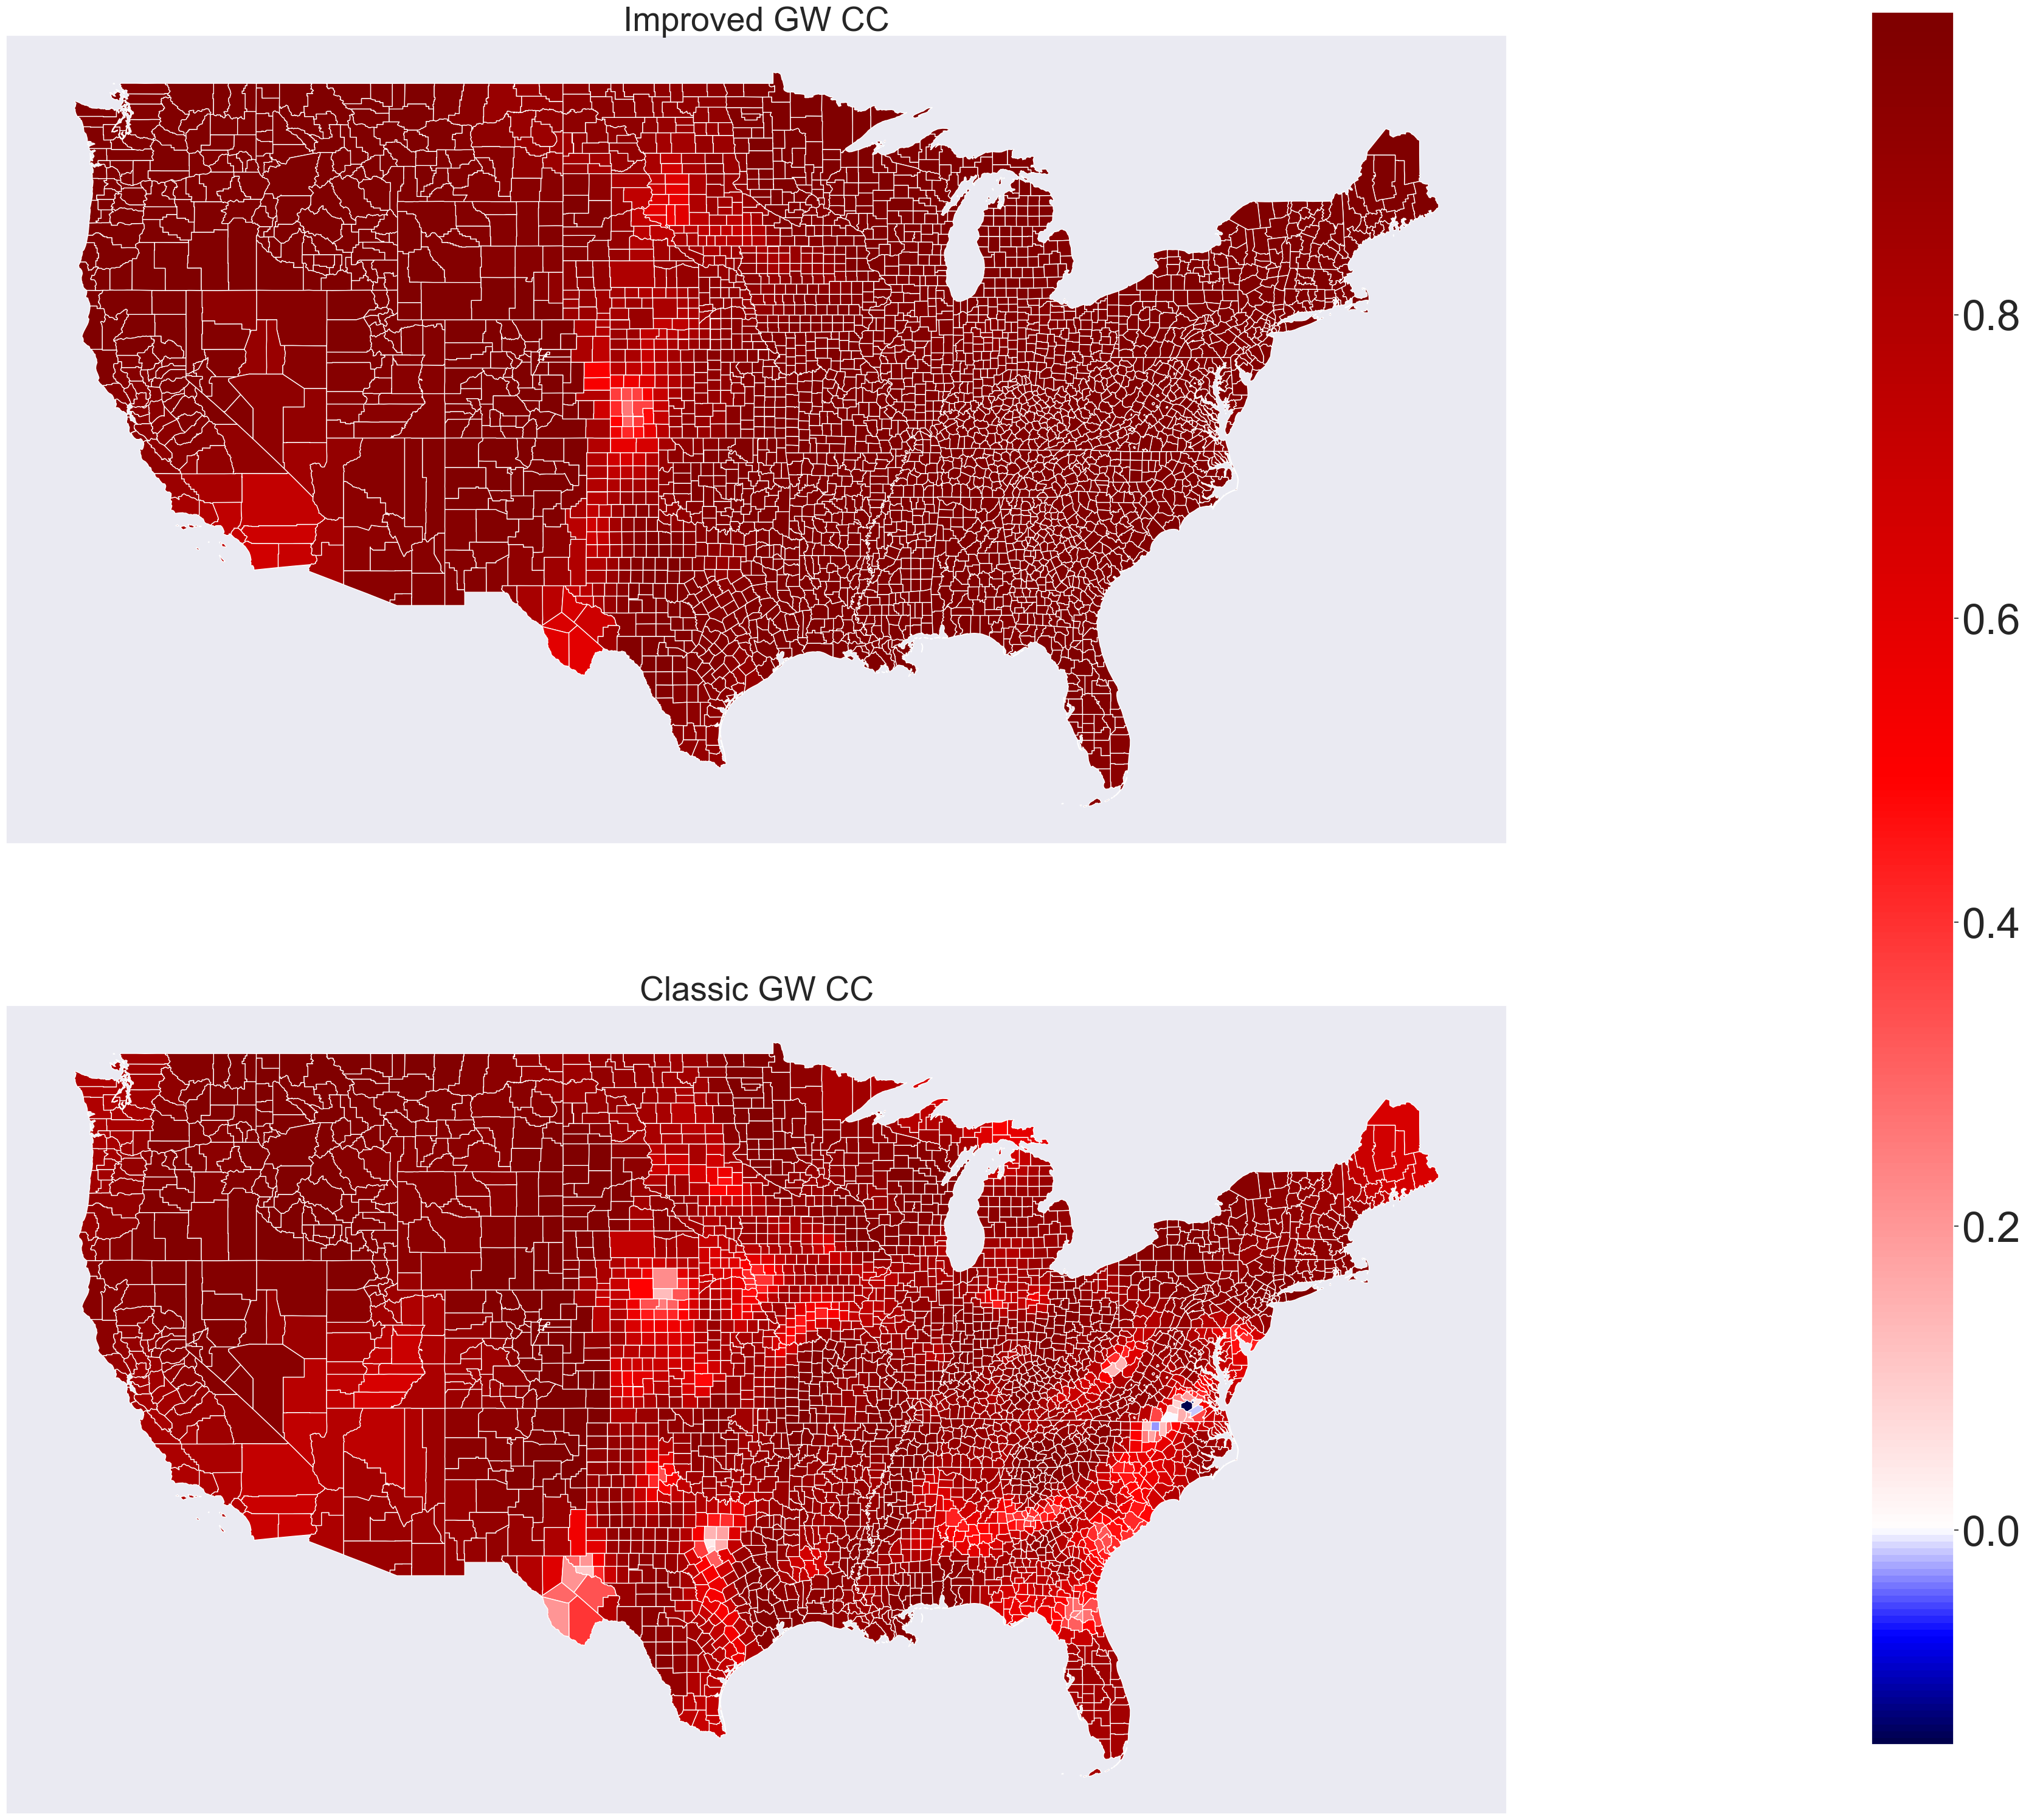

In [35]:
compare_surfaces(gdf, 'new_algo_params', 'gwr_calc', savefig='./figs/gedi_fia.png')

In [36]:
corr = []

for i in range(len(g_X)):
    wi = gwr_results_o.model._build_wi(i, gwr_bw_o).reshape(-1,1)
    xw = g_X*wi
    yw = g_y*wi
    corr_coef, _ = stats.pearsonr(xw.flatten(), yw.flatten())
    corr.append(corr_coef)

np.array(corr).mean()

0.9642176057454812

#### END